HEAT MAP

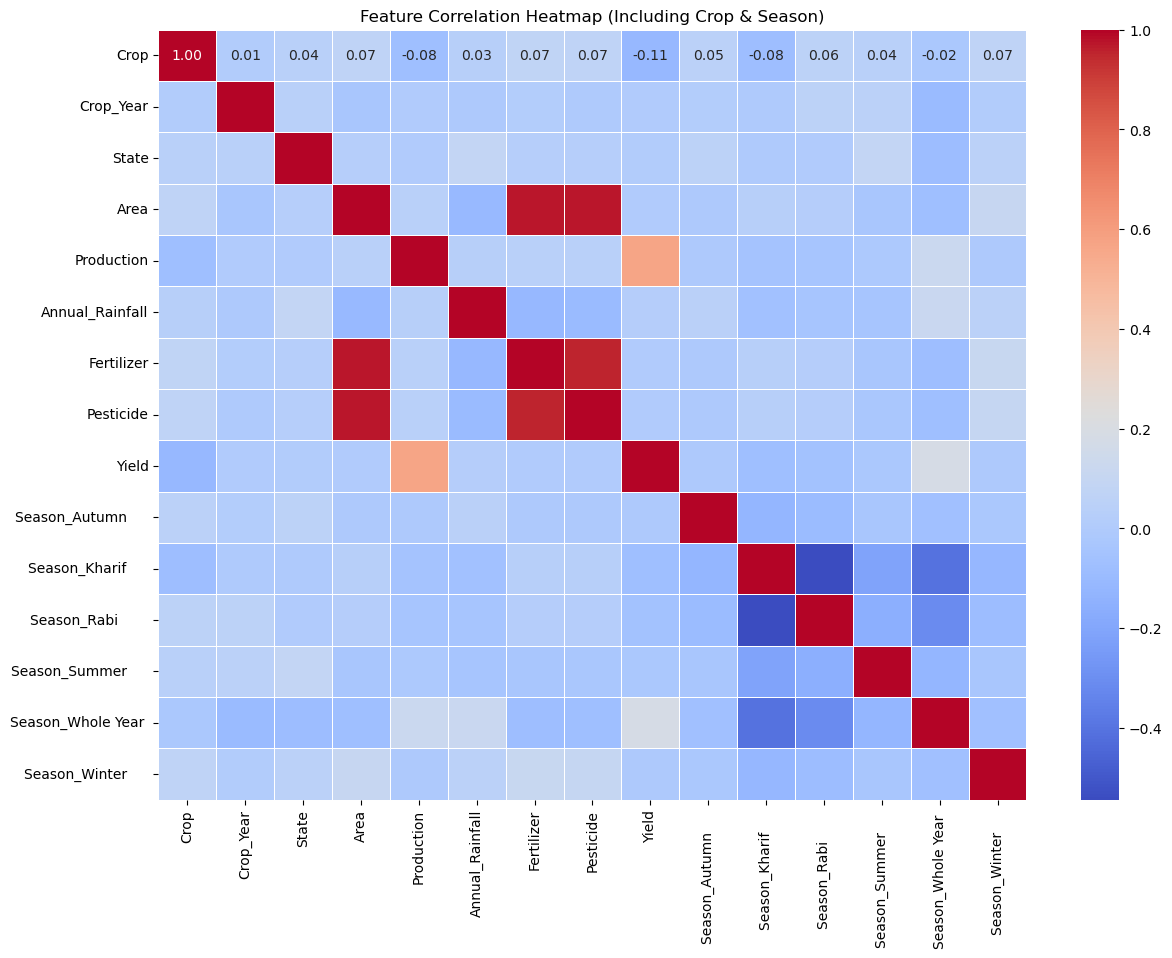

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
df = pd.read_csv("crop_yield.csv")  # Replace with actual filename

# Convert categorical 'Crop' into numeric using label encoding
df["Crop"] = df["Crop"].astype("category").cat.codes

# Convert categorical 'Season' into numeric using one-hot encoding
df = pd.get_dummies(df, columns=["Season"], drop_first=False)  # Keep all season columns

# Convert Season columns from boolean to integer (0 or 1)
season_columns = [col for col in df.columns if "Season_" in col]
df[season_columns] = df[season_columns].astype(int)

# Convert any other categorical column (e.g., 'State', 'District') into numerical values
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].astype("category").apply(lambda x: x.cat.codes)

# Ensure all relevant columns are numeric
df_numeric = df.select_dtypes(include=[np.number])

# Compute correlation matrix
correlation_matrix = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap (Including Crop & Season)")
plt.show()


Feature	Correlation with Yield
Crop	0.07 (Low correlation)
Crop_Year	0.04 (Very low)
State	0.06 (Very low)
Area	0.07 (Low)
Production	0.6 (Moderate-High)
Annual_Rainfall	-0.08 (Negative, Low)
Fertilizer	0.04 (Very low)
Pesticide	-0.02 (Very low)
Season_Autumn	0.04 (Low)
Season_Kharif	0.06 (Low)
Season_Rabi	-0.08 (Negative, Low)
Season_Summer	0.04 (Low)
Season_Whole Year	-0.02 (Very low)
Season_Winter	0.07 (Low)


✅ Recommended Inputs for Web App
Fields users should enter for yield prediction:

Crop (Dropdown - Type of crop)
Season (Dropdown - Select season)
Area (Numeric - Land area in hectares)
Annual Rainfall (Numeric - in mm)
Fertilizer Used (Numeric - in kg)

🚀 These inputs are sufficient for prediction while avoiding redundancy.

In [2]:
import pandas as pd

df = pd.read_csv("crop_yield.csv")  # Load your dataset
print(df.columns)  # Show column names


Index(['Crop', 'Crop_Year', 'Season', 'State', 'Area', 'Production',
       'Annual_Rainfall', 'Fertilizer', 'Pesticide', 'Yield'],
      dtype='object')


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
import pickle
from sklearn.metrics import r2_score

# Load dataset (Assume CSV for now)
data = pd.read_csv("crop_yield.csv")

# Selecting relevant features
categorical_features = ["Crop", "Season"]
numerical_features = ["Area", "Production", "Annual_Rainfall", "Fertilizer"]
label = "Yield"

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Updated for sklearn 1.4+
categorical_encoded = encoder.fit_transform(data[categorical_features])
encoded_columns = encoder.get_feature_names_out(categorical_features)
categorical_df = pd.DataFrame(categorical_encoded, columns=encoded_columns)

# Combining processed data
data_processed = pd.concat([categorical_df, data.drop(columns=categorical_features)], axis=1)

# Updating feature list to include encoded categorical features
features = list(encoded_columns) + numerical_features

# Splitting data
X = data_processed[features]
y = data_processed[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_preds = rf.predict(X_test_scaled)
rf_r2 = r2_score(y_test, rf_preds)

# Save Random Forest Model
with open("random_forest.pkl", "wb") as f:
    pickle.dump(rf, f)

# Train RNN Model
rnn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer
])

rnn_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
rnn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))
rnn_preds = rnn_model.predict(X_test_scaled).flatten()
rnn_r2 = r2_score(y_test, rnn_preds)

# Save RNN Model
rnn_model.save("rnn_model.keras")

# Ensemble Prediction Function
def ensemble_predict(X):
    rf_pred = rf.predict(X)
    rnn_pred = rnn_model.predict(X).flatten()
    return (rf_pred + rnn_pred) / 2  # Averaging predictions

# Evaluate Ensemble Model
ensemble_preds = ensemble_predict(X_test_scaled)
ensemble_r2 = r2_score(y_test, ensemble_preds)

# Print results
print(f"Random Forest R² Score: {rf_r2:.4f}")
print(f"RNN R² Score: {rnn_r2:.4f}")
print(f"Ensemble Model R² Score: {ensemble_r2:.4f}")


C:\Users\deeks\miniproject\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 424729.7812 - mae: 58.0187 - val_loss: 129268.3359 - val_mae: 31.5443
Epoch 2/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 127611.6797 - mae: 31.3810 - val_loss: 128942.8203 - val_mae: 30.1596
Epoch 3/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 103853.0938 - mae: 28.0315 - val_loss: 111566.7422 - val_mae: 26.3141
Epoch 4/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 77099.2266 - mae: 24.1592 - val_loss: 108372.2109 - val_mae: 25.6430
Epoch 5/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 81354.9844 - mae: 23.4868 - val_loss: 109996.2266 - val_mae: 25.2512
Epoch 6/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 80657.6562 - mae: 22.8256 - val_loss: 115232.8516 - val_mae: 27.7564
Epoch 7/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 76642.9141 - mae: 24.1362 - val_loss: 157750.1250 - val_mae: 32.0075
Epoch 8/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 102878.2109 - mae: 25.7549 - val_l

Clarification of Inputs:
Crop - Type of crop (e.g., Rice, Wheat, Maize).
Season - The growing season (e.g., Kharif, Rabi, Summer).
Area - The amount of land used for cultivation (in hectares).
Production - The total harvested crop output (in metric tons or kg).
Annual Rainfall - The total rainfall in a year (in mm).
Fertilizer Used - The amount of fertilizer applied (in kg).

In [4]:
# Sample data for encoding (Should match the training dataset)
crop_categories = ['Wheat', 'Rice', 'Maize', 'Barley']  
season_categories = ['Kharif', 'Rabi', 'Zaid']  

# Create a DataFrame covering all category combinations
sample_data = pd.DataFrame({
    'Crop': crop_categories * len(season_categories),  # Repeat crops for each season
    'Season': season_categories * len(crop_categories)  # Repeat seasons accordingly
})

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoder.fit(sample_data)


OneHotEncoder(drop='first', sparse_output=False)

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import pickle

# Load dataset
data = pd.read_csv("crop_yield.csv")

# Define features
categorical_features = ["Crop", "Season"]
numerical_features = ["Area", "Production", "Annual_Rainfall", "Fertilizer"]
label = "Yield"

# One-hot encoding categorical features
encoder = OneHotEncoder(sparse_output=False, drop='first')
categorical_encoded = encoder.fit_transform(data[categorical_features])
encoded_columns = encoder.get_feature_names_out(categorical_features)
categorical_df = pd.DataFrame(categorical_encoded, columns=encoded_columns)

# Merge encoded categorical features
data_processed = pd.concat([categorical_df, data.drop(columns=categorical_features)], axis=1)

# Define final features list
features = list(encoded_columns) + numerical_features

# Split dataset
X = data_processed[features]
y = data_processed[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Save Random Forest Model
with open("random_forest.pkl", "wb") as f:
    pickle.dump(rf, f)

# Save Encoder
with open("encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)

# Save Scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Train RNN model
rnn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

rnn_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
rnn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))

# Save RNN Model
rnn_model.save("rnn_model.keras")

print("✅ Models, encoder, and scaler saved successfully!")


Epoch 1/50


C:\Users\deeks\miniproject\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


493/493 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 418817.2812 - mae: 67.1156 - val_loss: 134002.2969 - val_mae: 33.7696
Epoch 2/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 99034.1328 - mae: 26.5337 - val_loss: 125435.8047 - val_mae: 35.4676
Epoch 3/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 114237.6484 - mae: 33.4407 - val_loss: 127008.1797 - val_mae: 30.2388
Epoch 4/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 87620.8125 - mae: 26.0338 - val_loss: 129329.4766 - val_mae: 30.6495
Epoch 5/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 93805.4453 - mae: 26.5025 - val_loss: 131245.5625 - val_mae: 30.1656
Epoch 6/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 108047.8516 - mae: 28.1559 - val_loss: 130964.7734 - val_mae: 36.9507
Epoch 7/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 93989.9062 - mae: 23.9807 - val_loss: 106563.9453 - val_mae: 29.5179
Epoch 8/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 95005.1016 - mae: 28.3429 - val_loss: 107724.